## Case #6 - Neural Networks
### Michael Catalano, Martin Garcia, Jeremy Otsap, Christian Nava
### 7/29/2020

## Introduction

Taken from the abstract of the white paper *Searching for Exotic Particles in High-Energy Physics with Deep Learning*, collisions at high-energy particle colliders are a source of exotic particle discoveries. Finding these rare particles requires solving difficult signal-versus-background classification problems.$^1$ The authors utilize a deep neural network approach to handle this classification task. From the results of the experiment, it is evident that deep learning approaches like neural networks can improve the power of collider searches for exotic particles when classifying either a signal versus background class.

As we dig deeper into the methods used by the authors in 2014, its incredible how far neural networks have come. Improvements in libraries, new activation functions, optimizers, and economies of scale have helped pave the way for building competing neural networks at home without the need of multi-core cloud solutions. Standard practices used when the paper was published have changed; modifications to the methods used in the paper might show comparable or even better performance at a fraction of the computation cost.

The following analysis replicates the deep learning model from the architecture used in the 2014 white paper, discusses the assumptions and a number of concepts used in the model, and proposes modifications where appropriate. In addition to replicating the model architecture from the paper, we create a handful of additional models for a comparison using different tuning parameters.

### Deep Neural Networks

In the white paper, the authors build and compare multiple deep neural networks before selecting the best-performing model for use in their final classification tool. In its most simplistic form, a neural network consists of nodes which make up layers of a network. A simple one-layer neural network contains an input layer, hidden layer, and an output layer. All inputs are modified by a weight and summed (linear combination). Finally, an activation function controls the amplitude of the output. The network essentially "learns" the distribution function of the observed data, and iteratively improves its predictive power by batching through training samples with the goal of minimizing a loss function.

The structure of a neural network dictates the depth and complexity, as "deep" neural networks often have multiple layers. Figure 1 below shows an example of a one-layer neural network.

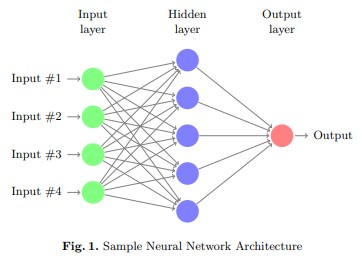

### Paper Methodology and Data

The authors select a five-layer neural network with 300 hidden units in each layer, a learning rate of 0.05, and a weight decay coefficient of 1 × 10−5.$^1$ Going back to Figure 1, we only show a single-layer network with five hidden units. You can imagine how large this structure would be to visualize with five layers and 300 units each!

Neural networks are subject to immense tuning, often governed by time and resources. One universally accepted notion is these networks require large training datasets. For example, the authors used 11 million simulated collision events for benchmarking, with 28 features. The authors split these features into low and high levels per the amount of discrimination power, though hyper-parameter optimization was performed using the full set of HIGGS features (all 28).$^1$

The training set consists of 2.6 million examples and 100,000 validation examples. The following hyperparameters are used in training (we describe the implications of these hyperparameters in the following section):

* Weights are initialized from a normal distribution with zero mean and standard deviation 0.1 in the first layer, 0.001 in the output layer, and 0.05 all other hidden layers
* Hidden units all use the tanh activation function
* Gradient computations are made on mini-batches of size 100
* A momentum term increases linearly over the first 200 epochs from 0.9 to 0.99, at which point it remains constant
* The learning rate decays by a factor of 1.0000002, every batch updates until it reaches a minimum of 10−6



### Hyperparameters within Neural Network Configurations

 * Learning rate: an important hyperparameter used in the training of neural networks, typically between 0 and 1. The learning rate controls how quickly the model is adapted to the problem. Smaller learning rates require more training epochs given the smaller changes made to the weights after each update, whereas larger learning rates result in rapid changes and require fewer training epochs.$^2$ So what does this mean, exactly? The learning rate controls the stability of a model; set it too small and the training process could get stuck and our model might not learn. Setting the value too large may result in learning a sub-optimal set of weights too quickly and overfitting might occur.

 * Weight decay coefficient: A parameter used to prevent a model from getting too complex; prevent overfitting by multiplying the sum of squares with a small, arbitrary value. A more technical definition: Weight decay specifies regularization in the neural network. During training, a regularization term is added to the network's loss to compute the backpropagation gradient. The weight decay value determines how dominant this regularization term will be in the gradient computation.$^3$

 * Activation function: Decides whether a neuron in the hidden layer should be activated based on the calculation of a weighted sum plus a bias term. The purpose of the activation function is to introduce non-linearity into the output of a neuron, else it is a linear regression model. The activation function does the non-linear transformation to the input making it capable to learn and perform more complex tasks.$^4$ The choice of which activation function to use is dependent on the output of a problem (classification, probabilistic prediction, etc.), however there is no hard or fast rule.

 * Batch size (aka mini-batches): When training a neural network, this is the number of samples that will be sent through the network at one time. Generally, the larger the batch size, the quicker the epochs run. There is a trade-off between batch size and computational resources on the machine one needs to be aware of.

 * Epoch: A single pass of all data through the network. Set in the configuration of your model.

### Evaluation Metrics: AUC

Performance is measured using a Receiver Operating Characteristic (ROC) curves that looks at a benchmark boosted decision tree, shallow and deep neural networks with three additional layers each based on features. The results for the table on the left look at the results for the Higgs and right for the SUSY benchmark. The AUC under the context of this study looks at classification accuracy for the new particle, Higgs Boson. The second benchmark is also a classification tasks between two processes with the goal of identifying those of the new particles. The goal for this metric is to have the largest area under the curve which demonstrate higher accuracy at different thresholds, or measure of true positive rate against false positive rate at varying settings for our model.

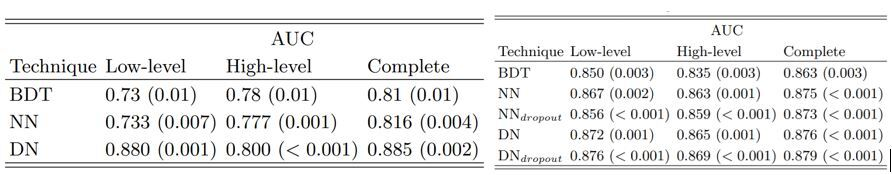

### Group Replication Method

The authors had the luxury of training 2.6 million observations on 16 Intel Xeon cores, an NVIDIA Tesla C2070 graphics processor, and 64 GB memory. Even with the constraints of replicating the paper architecture on local machines, we are able to maximize a validation AUC of 82% by training on a subset of 250,000 observations, 25,000 of which are held out for validation (90/10 split).

### Optimization Techniques

In addition to the replicated white paper model, we create a handful of models that consist of different tuning parameters. Our baseline model is a Random Forest model with a max depth of 10, and 30 estimators. A second Neural Network (NN_paper_optimized) consists of changing the optimizer to ADAM and changing the activation function to ReLu, an all-around good approximator that is less costly than what the authors used (tanh). With the tanh activation function, the activations are dense. All neurons fire in an analog way. Ideally, we want neurons in our network to not activate, thereby making the activations sparse and efficient. ReLu is advantageous in this regard, its less computationally expensive. The opimized neural network shows marginal improvements over the replication model (NN_paper).

We round out the third model (H2O_optimized) using H2O, a tool for solving ML problems in a fast, scalable environment. Results of all our models are shown here:

### Model Results

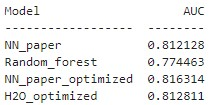

## Replication of White Paper Model

#### Import Libraries

In [1]:
import os
import logging
import logging.config
import numpy as np 
import pandas as pd
import tensorflow as tf
import pandas as pd 
import pandas_profiling as pp
import matplotlib.pyplot as plt
import seaborn as sns

# Remove scientific notation
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [2]:
# From https://arxiv.org/abs/1402.4735

#### Retrieve Data

In [3]:
# Downloads a file from a URL if it not already in the cache. Will save in .keraset/dataset folder
gz = tf.keras.utils.get_file('HIGGS.csv.gz', 'http://mlphysics.ics.uci.edu/data/higgs/HIGGS.csv.gz')

Contains 11,000,000 examples, each with 28 features, and a binary class label.

In [4]:
higgs = pd.read_csv('.keras/datasets/HIGGS.csv.gz',nrows = 250000, skiprows = 10)

Sample of 250,000 records from the first 2.5 million (skiprows of 10)

In [5]:
higgs.head()

,1.000000000000000000e+00,9.459739923477172852e-01,1.111244320869445801e+00,1.218337059020996094e+00,9.076390862464904785e-01,8.215369582176208496e-01,1.153243303298950195e+00,-3.654202818870544434e-01,-1.566054821014404297e+00,0.000000000000000000e+00,...,-4.510180354118347168e-01,6.365344673395156860e-02,3.101961374282836914e+00,8.290241360664367676e-01,9.806482791900634766e-01,9.943597912788391113e-01,9.082478284835815430e-01,7.758789062500000000e-01,7.833113670349121094e-01,7.251217961311340332e-01
0,0.00000,0.73936,-0.17829,0.82993,0.50454,-0.13022,0.96105,-0.35552,-1.71740,2.17308,...,0.77406,0.39882,3.10196,0.94454,1.02626,0.98220,0.54211,1.25098,0.83004,0.76131
1,1.00000,1.38410,0.11682,-1.17988,0.76291,-0.07978,1.01986,0.87732,1.27689,2.17308,...,0.84652,0.50481,3.10196,0.95932,0.80738,1.19181,1.22121,0.86114,0.92934,0.83830
2,1.00000,1.38355,0.88918,0.61853,1.08155,0.34461,0.95638,0.85454,-1.12921,2.17308,...,-1.63613,1.14407,0.00000,0.52224,0.73764,0.98620,1.34962,0.81279,0.95341,0.77972
3,1.00000,1.34365,0.83853,-1.06114,2.47202,-0.57263,1.51271,1.14369,0.85556,0.00000,...,2.39640,0.75729,0.00000,0.93402,0.84471,1.07784,1.40018,0.94777,1.00761,0.90102
4,0.00000,0.54701,-0.34971,-0.64666,2.04046,0.27646,0.54470,0.83870,1.72870,0.00000,...,-0.62924,1.57079,3.10196,0.68943,0.86723,1.08249,0.66414,0.35411,0.57995,0.81727


#### Preprocessing

In [6]:
# Rename columns
higgs.columns = ['label','lepton_pT','lepton_eta','lepton_phi','missing_energy_magnitude','missing_energy_phi','jet_1_pt','jet_1_eta','jet_1_phi','jet_1_b_tag','jet_2_pt','jet_2_eta','jet_2_phi','jet_2_b_tag','jet_3_pt','jet_3_eta','jet_3_phi','jet_3_b-tag','jet_4_pt','jet_4_eta','jet_4_phi','jet_4_b_tag','m_jj','m_jjj','m_lv','m_jlv','m_bb','m_wbb','m_wwbb']

In [7]:
higgs.head()

,label,lepton_pT,lepton_eta,lepton_phi,missing_energy_magnitude,missing_energy_phi,jet_1_pt,jet_1_eta,jet_1_phi,jet_1_b_tag,...,jet_4_eta,jet_4_phi,jet_4_b_tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb
0,0.00000,0.73936,-0.17829,0.82993,0.50454,-0.13022,0.96105,-0.35552,-1.71740,2.17308,...,0.77406,0.39882,3.10196,0.94454,1.02626,0.98220,0.54211,1.25098,0.83004,0.76131
1,1.00000,1.38410,0.11682,-1.17988,0.76291,-0.07978,1.01986,0.87732,1.27689,2.17308,...,0.84652,0.50481,3.10196,0.95932,0.80738,1.19181,1.22121,0.86114,0.92934,0.83830
2,1.00000,1.38355,0.88918,0.61853,1.08155,0.34461,0.95638,0.85454,-1.12921,2.17308,...,-1.63613,1.14407,0.00000,0.52224,0.73764,0.98620,1.34962,0.81279,0.95341,0.77972
3,1.00000,1.34365,0.83853,-1.06114,2.47202,-0.57263,1.51271,1.14369,0.85556,0.00000,...,2.39640,0.75729,0.00000,0.93402,0.84471,1.07784,1.40018,0.94777,1.00761,0.90102
4,0.00000,0.54701,-0.34971,-0.64666,2.04046,0.27646,0.54470,0.83870,1.72870,0.00000,...,-0.62924,1.57079,3.10196,0.68943,0.86723,1.08249,0.66414,0.35411,0.57995,0.81727


In [8]:
higgs.describe(include='all')

,label,lepton_pT,lepton_eta,lepton_phi,missing_energy_magnitude,missing_energy_phi,jet_1_pt,jet_1_eta,jet_1_phi,jet_1_b_tag,...,jet_4_eta,jet_4_phi,jet_4_b_tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb
count,250000.00000,250000.00000,250000.00000,250000.00000,250000.00000,250000.00000,250000.00000,250000.00000,250000.00000,250000.00000,...,250000.00000,250000.00000,250000.00000,250000.00000,250000.00000,250000.00000,250000.00000,250000.00000,250000.00000,250000.00000
mean,0.52776,0.99242,0.00036,-0.00186,0.99711,-0.00341,0.98970,-0.00418,-0.00031,0.99981,...,-0.00159,-0.00048,0.99581,1.03449,1.02434,1.05057,1.01053,0.97331,1.03333,0.95999
std,0.49923,0.56564,1.00673,1.00591,0.59799,1.00660,0.47523,1.00894,1.00769,1.02791,...,1.00898,1.00664,1.39814,0.66315,0.37631,0.16456,0.39852,0.52361,0.36465,0.31314
min,0.00000,0.27470,-2.43498,-1.74251,0.00086,-1.74394,0.13998,-2.96973,-1.74124,0.00000,...,-2.49726,-1.74269,0.00000,0.10967,0.24532,0.13301,0.15747,0.04813,0.30335,0.35094
25%,0.00000,0.59185,-0.73637,-0.87360,0.57645,-0.87491,0.67817,-0.69220,-0.86865,0.00000,...,-0.71669,-0.87328,0.00000,0.79098,0.84619,0.98578,0.76834,0.67452,0.81977,0.77038
50%,1.00000,0.85392,-0.00005,0.00042,0.89068,-0.00448,0.89354,-0.00498,-0.00382,1.08654,...,-0.00462,-0.00193,0.00000,0.89527,0.95025,0.98976,0.91708,0.87394,0.94715,0.87169
75%,1.00000,1.23806,0.73919,0.86766,1.29174,0.86920,1.16918,0.68224,0.87108,2.17308,...,0.71410,0.86994,3.10196,1.02520,1.08271,1.02044,1.14223,1.13997,1.14008,1.05973
max,1.00000,7.80589,2.43487,1.74324,8.77406,1.74323,7.07693,2.96967,1.74145,2.17308,...,2.49801,1.74337,3.10196,18.42883,10.03827,5.64642,10.46832,13.73569,8.43236,6.01565


In [9]:
higgs.dtypes

label                       float64
lepton_pT                   float64
lepton_eta                  float64
lepton_phi                  float64
missing_energy_magnitude    float64
missing_energy_phi          float64
jet_1_pt                    float64
jet_1_eta                   float64
jet_1_phi                   float64
jet_1_b_tag                 float64
jet_2_pt                    float64
jet_2_eta                   float64
jet_2_phi                   float64
jet_2_b_tag                 float64
jet_3_pt                    float64
jet_3_eta                   float64
jet_3_phi                   float64
jet_3_b-tag                 float64
jet_4_pt                    float64
jet_4_eta                   float64
jet_4_phi                   float64
jet_4_b_tag                 float64
m_jj                        float64
m_jjj                       float64
m_lv                        float64
m_jlv                       float64
m_bb                        float64
m_wbb                       

In [10]:
#change label to int
higgs["label"] = higgs["label"].astype(int)

In [11]:
dataset = higgs.values

In [12]:
# split into input (X) and output (Y) arrays
X = dataset[:,1:29].astype(float)
Y = dataset[:,0]

In [13]:
# visualize data
X[0:3]

array([[ 0.73935676, -0.17829043,  0.82993424,  0.50453907, -0.13021675,
         0.96105134, -0.35551798, -1.71739936,  2.17307615,  0.62095606,
        -0.48174104, -1.19919324,  0.        ,  0.9826014 ,  0.08118503,
        -0.29032364,  0.        ,  1.06466293,  0.77406496,  0.39882034,
         3.10196137,  0.94453603,  1.02626061,  0.98219675,  0.54211468,
         1.25097895,  0.83004463,  0.76130795],
       [ 1.3840977 ,  0.11682209, -1.17987895,  0.76291257, -0.07978227,
         1.01986313,  0.87731826,  1.27688718,  2.17307615,  0.3312521 ,
         1.40952349, -1.47438884,  0.        ,  1.28273821,  0.73747438,
        -0.22541961,  0.        ,  1.55975306,  0.84652054,  0.50480855,
         3.10196137,  0.95932466,  0.80737603,  1.19181359,  1.22121036,
         0.86114126,  0.9293409 ,  0.83830237],
       [ 1.38354874,  0.88917929,  0.61853206,  1.08154702,  0.34460557,
         0.95637935,  0.85454297, -1.12920702,  2.17307615,  0.54566574,
        -0.30786517, -0.6232

In [14]:
Y[0:3]

array([0., 1., 1.])

### Normalization

Normalizing the data generally speeds up learning and leads to faster convergence (the network is more able to find a reasonable minima in its loss function.) L2 normalization is used here. L2 calculates the square root of the sum of the squared vector values (Euclidean distance from the origin.)

In [15]:
from sklearn import preprocessing

# Normalize X values
normalized_X = preprocessing.normalize(X, norm='l2', axis=1, copy=True, return_norm=False)

In [16]:
normalized_X[0:3]

array([[ 0.13295555, -0.03206125,  0.14924374,  0.09072923, -0.02341635,
         0.172822  , -0.06393137, -0.30883302,  0.39077555,  0.11166403,
        -0.08662956, -0.2156461 ,  0.        ,  0.17669726,  0.01459918,
        -0.05220773,  0.        ,  0.19145406,  0.13919699,  0.07171826,
         0.55781325,  0.16985212,  0.18454832,  0.17662449,  0.0974863 ,
         0.22495852,  0.14926359,  0.13690295],
       [ 0.22335446,  0.0188518 , -0.19039929,  0.12311264, -0.01287462,
         0.16457724,  0.1415745 ,  0.20605369,  0.3506734 ,  0.05345478,
         0.22745747, -0.23792491,  0.        ,  0.20699789,  0.11900763,
        -0.03637639,  0.        ,  0.2517003 ,  0.13660462,  0.08146191,
         0.50056936,  0.15480803,  0.13028779,  0.19232521,  0.19706902,
         0.13896399,  0.14996949,  0.13527844],
       [ 0.25562701,  0.1642864 ,  0.11428112,  0.19982862,  0.06366996,
         0.17670241,  0.15788693, -0.20863437,  0.40150155,  0.10081821,
        -0.05688174, -0.1151

#### Model Building: Model 1

The following lines of code attempt to recreate the NN architecture from the white paper

In [17]:
# train/test split
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(normalized_X, Y, test_size=0.10, random_state=1776)

# 225,000 samples will be training, 25,000 will be held out for validation

In [18]:
from time import time
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
es = EarlyStopping(min_delta=0,patience=25)

# early stopping implemented to avoid overfitting. Set the limit with min_delta - the patience tells you the number of epochs to run before stopping.
# So you'd interpret this as - if the loss of the epoch does not change (improve) at the thousanth decimal point for 10 straight epochs, then stop training.

In [19]:
# build model architecture from white paper

from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import add
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import backend as K
from tensorflow.keras.initializers import RandomNormal

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.05,
    decay_steps=10000,
    decay_rate=1.0000002)

l1init = RandomNormal(mean=0.0, stddev=0.1, seed=None) # original model parameters for initializing input layer
hiddeninit = RandomNormal(mean=0.0, stddev=0.05, seed=None) # original model parameters for initializing hidden layers
outputinit = RandomNormal(mean=0.0, stddev=0.001, seed=None) # original model parameters for initializing output layer

model1 = Sequential()
model1.add(Dense(300, input_dim=28, activation='tanh',kernel_initializer=l1init))
model1.add(Dense(300, activation='tanh',kernel_initializer=hiddeninit))
model1.add(Dense(300, activation='tanh',kernel_initializer=hiddeninit))
model1.add(Dense(300, activation='tanh',kernel_initializer=hiddeninit))
model1.add(Dense(1, activation='sigmoid',kernel_initializer=outputinit))
# Compile model

model1.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9),
              loss='binary_crossentropy',metrics=['accuracy'])

In [20]:
# prints out the number of weights in your NN
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 300)               8700      
_________________________________________________________________
dense_1 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_2 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_3 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 301       
Total params: 279,901
Trainable params: 279,901
Non-trainable params: 0
_________________________________________________________________


In [21]:
# fit model from paper
history1 = model1.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=300, batch_size=500,callbacks=[es])

Epoch 1/300
450/450 [==============================] - 3s 7ms/step - loss: 0.6666 - accuracy: 0.5856 - val_loss: 0.6485 - val_accuracy: 0.6215
Epoch 2/300
450/450 [==============================] - 3s 7ms/step - loss: 0.6467 - accuracy: 0.6221 - val_loss: 0.6433 - val_accuracy: 0.6240
Epoch 3/300
450/450 [==============================] - 3s 6ms/step - loss: 0.6447 - accuracy: 0.6262 - val_loss: 0.6417 - val_accuracy: 0.6265
Epoch 4/300
450/450 [==============================] - 3s 7ms/step - loss: 0.6443 - accuracy: 0.6263 - val_loss: 0.6474 - val_accuracy: 0.6137
Epoch 5/300
450/450 [==============================] - 3s 7ms/step - loss: 0.6421 - accuracy: 0.6306 - val_loss: 0.6381 - val_accuracy: 0.6353
Epoch 6/300
450/450 [==============================] - 3s 7ms/step - loss: 0.6409 - accuracy: 0.6325 - val_loss: 0.6407 - val_accuracy: 0.6277
Epoch 7/300
450/450 [==============================] - 3s 7ms/step - loss: 0.6400 - accuracy: 0.6336 - val_loss: 0.6414 - val_accuracy: 0.6326

In [23]:
# build ROC curve metric
from sklearn.metrics import roc_curve

y_pred_keras = model1.predict(x_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)

In [24]:
# auc metric for model 1
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)
auc_keras

0.8121281192344099

81% AUC using the book's parameters

In [47]:
# accuracy
scores_paper = model1.evaluate(x_test, y_test, verbose=0)
print('Test accuracy:', scores_paper[1])

Test accuracy: 0.7334399819374084


##### Model Accuracy Plot - White Paper Model

Note our validation accuracy reaches a peak of 73% around the 80-epoch mark.

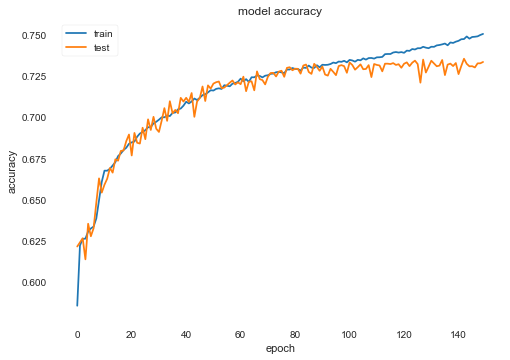

In [26]:
# summarize history for accuracy
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

##### Model Loss Plot - White Paper Model

Note our validation loss reaches the lowest point around the 110-epoch mark

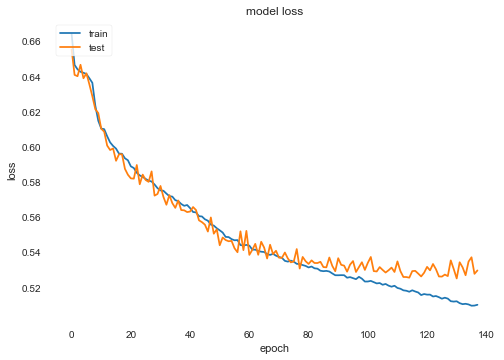

In [32]:
# summarize history for loss
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

We'll now use a baseline Random Forest Classifier to compare with the paper's NN

In [29]:
from sklearn.ensemble import RandomForestClassifier
# Supervised transformation based on random forests - my simple model to compare with
rf = RandomForestClassifier(max_depth=10, n_estimators=30)
rf.fit(x_train, y_train)

y_pred_rf = rf.predict_proba(x_test)[:, 1]
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_pred_rf)
auc_rf = auc(fpr_rf, tpr_rf)

##### Combined ROC Curve using the white paper's results and the baseline RF model

Note the NN from the paper outperforms our baseline Random Forest model

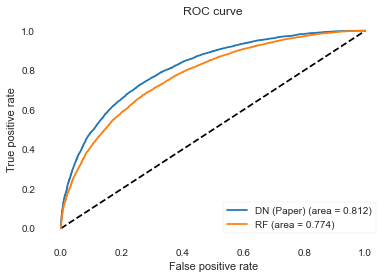

In [31]:
# ROC curve for both the paper's neural network and a baseline RF model

%matplotlib inline
from matplotlib import pyplot as plt

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='DN (Paper) (area = {:.3f})'.format(auc_keras))
plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

## Model Building: Model 2 with Hypertuning

In [32]:
# train/test split (should match above)
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(normalized_X, Y, test_size=0.10, random_state=1776)

In [33]:
from time import time
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
es = EarlyStopping(min_delta=0,patience=25)

In [34]:
# build model architecture using new set of parameters for activation function, dropouts, and a new optimizer

from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import add
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import backend as K
from tensorflow.keras.initializers import RandomNormal

model2 = Sequential()
model2.add(Dense(300, input_dim=28, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(300, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(300, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(300, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(1, activation='sigmoid'))
# Compile model
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

We've done a few things differently in this model, namely used a different activation function, a different optimizer, lowered the neurons in each hidden layer, and added a dropout after every additional hidden layer. Let's see how the model performs.

In [35]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 300)               8700      
_________________________________________________________________
dropout (Dropout)            (None, 300)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 300)               90300     
_________________________________________________________________
dropout_1 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 300)               90300     
_________________________________________________________________
dropout_2 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 300)              

In [36]:
# fit model
history2 = model2.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=300, batch_size=500,callbacks=[es])

Epoch 1/300
450/450 [==============================] - 4s 9ms/step - loss: 0.6633 - accuracy: 0.5920 - val_loss: 0.6304 - val_accuracy: 0.6423
Epoch 2/300
450/450 [==============================] - 4s 9ms/step - loss: 0.6334 - accuracy: 0.6396 - val_loss: 0.6154 - val_accuracy: 0.6613
Epoch 3/300
450/450 [==============================] - 4s 9ms/step - loss: 0.6192 - accuracy: 0.6567 - val_loss: 0.6008 - val_accuracy: 0.6714
Epoch 4/300
450/450 [==============================] - 4s 9ms/step - loss: 0.6101 - accuracy: 0.6659 - val_loss: 0.5921 - val_accuracy: 0.6816
Epoch 5/300
450/450 [==============================] - 4s 9ms/step - loss: 0.6041 - accuracy: 0.6727 - val_loss: 0.5881 - val_accuracy: 0.6859
Epoch 6/300
450/450 [==============================] - 4s 9ms/step - loss: 0.6007 - accuracy: 0.6747 - val_loss: 0.5873 - val_accuracy: 0.6860
Epoch 7/300
450/450 [==============================] - 4s 9ms/step - loss: 0.5972 - accuracy: 0.6780 - val_loss: 0.5807 - val_accuracy: 0.6914

In [40]:
from sklearn.metrics import roc_curve

y_pred_keras = model2.predict(x_test).ravel()
fpr_keras2, tpr_keras2, thresholds_keras2 = roc_curve(y_test, y_pred_keras)

In [41]:
# auc metric for model 2
from sklearn.metrics import auc
auc_keras2 = auc(fpr_keras2, tpr_keras2)
auc_keras2

0.8163138470424026

#### Seeing a negligible improvement in AUC by using different hyperparameters

In [46]:
# Accuracy - Optimized Model
scores_opt = model2.evaluate(x_test, y_test, verbose=0)
print('Test accuracy:', scores_opt[1])

Test accuracy: 0.7338799834251404


#### Comparisons Between NN Models

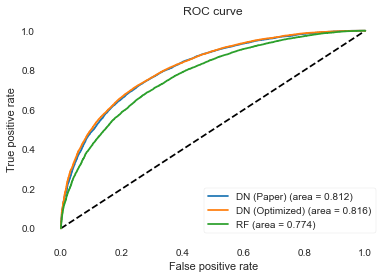

In [43]:
# ROC curve using all three models: paper architecture, RF, and optimized NN
%matplotlib inline
from matplotlib import pyplot as plt

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='DN (Paper) (area = {:.3f})'.format(auc_keras))
plt.plot(fpr_keras2, tpr_keras2, label='DN (Optimized) (area = {:.3f})'.format(auc_keras2))
plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

You can see marginal differences between the white paper's neural network and our optimized model (four one thousandths of a percent increase in AUC). It was worth noting, the optimized model ran slower due to the dropouts being used after each hidden layer.

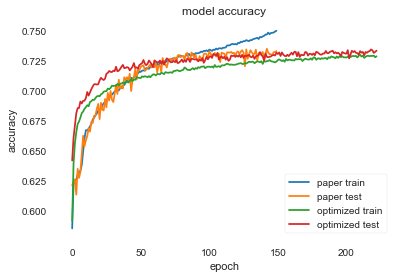

In [44]:
# summarized history for accuracy - both models
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['paper train', 'paper test','optimized train','optimized test'], loc='lower right')
plt.show()

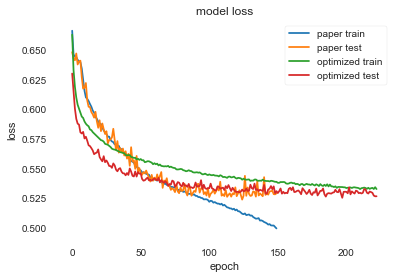

In [45]:
# summarized history for loss - both models
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['paper train', 'paper test','optimized train','optimized test'], loc='upper right')
plt.show()

## Model Building: Neural Networks using H2O

In [48]:
import h2o
from h2o.estimators.deeplearning import H2ODeepLearningEstimator
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [76]:
h2o.init()           
h2o.remove_all()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,22 mins 30 secs
H2O_cluster_timezone:,America/Chicago
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.0.6
H2O_cluster_version_age:,29 days
H2O_cluster_name:,H2O_from_python_Mike_24ut08
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.910 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


In [77]:
hf = h2o.H2OFrame(higgs)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [78]:
# change label to a factor so h2o recognizes it as a classification problem
hf['label'] = hf['label'].asfactor()

In [79]:
train, valid = hf.split_frame([0.9])
higgs_X = hf.col_names[1:]
higgs_y = hf.col_names[0]

In [80]:
# check out our training set
train.describe()

Rows:224917
Cols:29




,label,lepton_pT,lepton_eta,lepton_phi,missing_energy_magnitude,missing_energy_phi,jet_1_pt,jet_1_eta,jet_1_phi,jet_1_b_tag,jet_2_pt,jet_2_eta,jet_2_phi,jet_2_b_tag,jet_3_pt,jet_3_eta,jet_3_phi,jet_3_b-tag,jet_4_pt,jet_4_eta,jet_4_phi,jet_4_b_tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb
type,enum,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real
mins,,0.27469664812088007,-2.434976100921631,-1.7425082921981812,0.0008573559462092817,-1.7439435720443723,0.13997583091259003,-2.9697251319885254,-1.7412374019622805,0.0,0.18910706043243408,-2.913089513778687,-1.7423716783523555,0.0,0.2636076211929321,-2.7296628952026367,-1.7420687675476072,0.0,0.36535415053367615,-2.4972648620605473,-1.742690801620483,0.0,0.10967338830232622,0.2453176081180573,0.13301192224025726,0.29598328471183777,0.04812500998377799,0.30334970355033875,0.35093879699707037
mean,,0.9922575227344778,-0.00017154474264624347,-0.00212480317176131,0.9973007157105975,-0.00273187637915998,0.9902470157032655,-0.00385664374812239,-0.0007889829508954643,0.9987375564819251,0.9923597957724741,0.0022430368509804605,0.00037909619642271245,1.002318828929792,0.993835031554275,0.0015540304352361363,-0.0009347655726687242,1.0043539398140546,0.9865012520409825,-0.0010095249676367346,-0.0010113109003733825,0.995041994213178,1.0349383670907493,1.0244416822672617,1.050425515215234,1.01005925517735,0.9739749635064152,1.033663637174849,0.9601609383589645
maxs,,7.80588674545288,2.4348678588867183,1.7432359457015991,7.998711109161378,1.7432292699813845,7.076932430267333,2.9696741104125977,1.7414537668228147,2.1730761528015137,11.64708137512207,2.9132099151611333,1.7431747913360591,2.2148721218109126,7.718206882476807,2.730008840560912,1.7428839206695554,2.548224449157715,7.705783367156982,2.498008966445923,1.743372321128845,3.1019613742828365,18.4288272857666,10.038272857666016,5.646420478820801,10.468321800231934,13.735691070556642,8.43235969543457,6.015646934509276
sigma,,0.565797928385797,1.0063797325870172,1.0057616464207424,0.5979035579590504,1.0072934342938855,0.476413737437479,1.0086881742111515,1.0075559571582282,1.0278175149911528,0.49980573901572856,1.0066606145761763,1.0065686116163979,1.0489599650928836,0.48838679746648106,1.009050037221718,1.0049490110747064,1.1955362558741691,0.5051003556473014,1.0089610879057758,1.0064333847257154,1.3976680238703234,0.6655783784121945,0.3776735212366877,0.1640145618920538,0.3979311369187784,0.5244907037954202,0.3656249567221268,0.31356319391582954
zeros,,0,0,0,0,0,0,0,0,110453,0,0,0,112583,0,0,0,127866,0,0,0,146083,0,0,0,0,0,0,0
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,1,1.3840976953506468,0.11682209372520444,-1.1798789501190183,0.7629125714302065,-0.07978226989507675,1.0198631286621092,0.8773182630538942,1.2768871784210205,2.1730761528015137,0.33125209808349604,1.4095234870910645,-1.4743888378143308,0.0,1.282738208770752,0.7374743819236755,-0.22541961073875424,0.0,1.5597530603408811,0.8465205430984498,0.5048085451126099,3.1019613742828365,0.9593246579170226,0.8073760271072387,1.1918135881423952,1.2212103605270384,0.8611412644386292,0.9293408989906312,0.8383023738861084
1,1,1.3835487365722654,0.8891792893409729,0.6185320615768433,1.0815470218658447,0.344605565071106,0.9563793540000916,0.8545429706573486,-1.1292070150375366,2.1730761528015137,0.5456657409667969,-0.30786517262458807,-0.6232798099517823,2.2148721218109126,0.34825712442398077,1.0242025852203367,0.1840776652097702,0.0,0.7813369035720826,-1.636125564575195,1.1440672874450686,0.0,0.5222384929656982,0.7376385331153869,0.9861995577812196,1.3496156930923462,0.8127878904342651,0.9534064531326292,0.7797226309776306
2,1,1.3436527252197263,0.8385329246520996,-1.0611385107040403,2.472015142440796,-0.5726317167282104,1.5127099752426147,1.1436901092529297,0.8555619716644287,0.0,0.88422030210495,1.4746055603027344,-1.36064875125885,1.1074360609054563,1.5872656106948853,2.234833478

In [105]:
higgs_model = H2ODeepLearningEstimator(model_id = 'higgs',
                                         hidden=[200,200,200,200],
                                         epochs=50)
higgs_model.train(higgs_X, higgs_y, training_frame = train, validation_frame = valid)
print(higgs_model)

deeplearning Model Build progress: |██████████████████████████████████████| 100%
Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  higgs


Status of Neuron Layers: predicting label, 2-class classification, bernoulli distribution, CrossEntropy loss, 126,802 weights/biases, 1.5 MB, 3,701,712 training samples, mini-batch size 1


,,layer,units,type,dropout,l1,l2,mean_rate,rate_rms,momentum,mean_weight,weight_rms,mean_bias,bias_rms
0,,1,28,Input,0.00000,,,,,,,,,
1,,2,200,Rectifier,0.00000,0.00000,0.00000,0.00653,0.00230,0.00000,-0.01163,0.36890,-0.24448,0.30902
2,,3,200,Rectifier,0.00000,0.00000,0.00000,0.00955,0.01035,0.00000,-0.04666,0.13633,0.85044,0.24437
3,,4,200,Rectifier,0.00000,0.00000,0.00000,0.02167,0.02223,0.00000,-0.02902,0.11567,0.55819,0.39538
4,,5,200,Rectifier,0.00000,0.00000,0.00000,0.05036,0.06543,0.00000,-0.02485,0.08360,0.80803,0.14872
5,,6,2,Softmax,,0.00000,0.00000,0.00377,0.00154,0.00000,0.01115,0.36821,0.02934,0.05809




ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.15836999609635505
RMSE: 0.3979572792352906
LogLoss: 0.4802171516418215
Mean Per-Class Error: 0.23285814788758474
AUC: 0.8496681711360884
AUCPR: 0.8626285909513505
Gini: 0.6993363422721768

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.41120611891486514: 


,,0,1,Error,Rate
0,0,3159.00000,1621.00000,0.3391,(1621.0/4780.0)
1,1,781.00000,4530.00000,0.1471,(781.0/5311.0)
2,Total,3940.00000,6151.00000,0.238,(2402.0/10091.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.41121,0.79044,236.00000
1,max f2,0.15538,0.87115,338.00000
2,max f0point5,0.59160,0.79371,166.00000
3,max accuracy,0.46466,0.76831,216.00000
4,max precision,0.99564,1.00000,0.00000
5,max recall,0.00544,1.00000,397.00000
6,max specificity,0.99564,1.00000,0.00000
7,max absolute_mcc,0.46466,0.53497,216.00000
8,max min_per_class_accuracy,0.51566,0.76569,195.00000
9,max mean_per_class_accuracy,0.52382,0.76714,192.00000



Gains/Lift Table: Avg response rate: 52.63 %, avg score: 51.18 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.01001,0.98156,1.90002,1.90002,1.00000,0.98773,1.00000,0.98773,0.01902,0.01902,90.00188,90.00188,0.01902
1,2,0.02002,0.97162,1.86239,1.88121,0.98020,0.97654,0.99010,0.98214,0.01864,0.03766,86.23947,88.12068,0.03724
2,3,0.03003,0.96400,1.86239,1.87494,0.98020,0.96803,0.98680,0.97744,0.01864,0.05630,86.23947,87.49361,0.05546
3,4,0.04004,0.95705,1.86239,1.87180,0.98020,0.96035,0.98515,0.97317,0.01864,0.07494,86.23947,87.18007,0.07368
4,5,0.05004,0.94843,1.80596,1.85863,0.95050,0.95237,0.97822,0.96901,0.01808,0.09301,80.59585,85.86323,0.09071
5,6,0.10009,0.90511,1.80220,1.83041,0.94851,0.92756,0.96337,0.94828,0.09019,0.18320,80.21961,83.04142,0.17546
6,7,0.15003,0.85652,1.76430,1.80841,0.92857,0.87967,0.95178,0.92544,0.08812,0.27132,76.43032,80.84063,0.25605
7,8,0.20008,0.80610,1.65546,1.77015,0.87129,0.83155,0.93165,0.90196,0.08285,0.35417,65.54619,77.01513,0.32530
8,9,0.30007,0.71441,1.51022,1.68354,0.79485,0.75981,0.88606,0.85459,0.15101,0.50518,51.02231,68.35372,0.43300
9,10,0.40006,0.62699,1.33510,1.59645,0.70268,0.67109,0.84023,0.80873,0.13350,0.63867,33.50975,59.64488,0.50374




ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.17678845081411448
RMSE: 0.42046218713947925
LogLoss: 0.5276045835265158
Mean Per-Class Error: 0.2645913843727441
AUC: 0.8128107610381495
AUCPR: 0.8253707555557922
Gini: 0.6256215220762991

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3552584333890178: 


,,0,1,Error,Rate
0,0,6562.00000,5275.00000,0.4456,(5275.0/11837.0)
1,1,1798.00000,11448.00000,0.1357,(1798.0/13246.0)
2,Total,8360.00000,16723.00000,0.282,(7073.0/25083.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.35526,0.76399,256.00000
1,max f2,0.15002,0.86494,337.00000
2,max f0point5,0.59882,0.75864,161.00000
3,max accuracy,0.50226,0.73488,200.00000
4,max precision,0.99491,1.00000,0.00000
5,max recall,0.00446,1.00000,398.00000
6,max specificity,0.99491,1.00000,0.00000
7,max absolute_mcc,0.53720,0.47016,187.00000
8,max min_per_class_accuracy,0.52117,0.73381,193.00000
9,max mean_per_class_accuracy,0.53720,0.73541,187.00000



Gains/Lift Table: Avg response rate: 52.81 %, avg score: 51.09 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.01001,0.98094,1.87100,1.87100,0.98805,0.98724,0.98805,0.98724,0.01872,0.01872,87.09953,87.09953,0.01847
1,2,0.02001,0.97201,1.82573,1.84836,0.96414,0.97636,0.97610,0.98180,0.01827,0.03699,82.57292,84.83623,0.03598
2,3,0.03002,0.96204,1.79555,1.83076,0.94821,0.96667,0.96680,0.97676,0.01797,0.05496,79.55519,83.07588,0.05285
3,4,0.04003,0.95238,1.77292,1.81630,0.93625,0.95716,0.95916,0.97186,0.01774,0.07270,77.29189,81.62988,0.06924
4,5,0.05003,0.94286,1.78801,1.81064,0.94422,0.94756,0.95618,0.96700,0.01789,0.09059,78.80076,81.06406,0.08595
5,6,0.10003,0.89809,1.73658,1.77363,0.91707,0.92044,0.93663,0.94373,0.08682,0.17741,73.65809,77.36255,0.16398
6,7,0.15002,0.84991,1.63994,1.72907,0.86603,0.87466,0.91310,0.92071,0.08199,0.25940,63.99364,72.90743,0.23177
7,8,0.20002,0.80119,1.55688,1.68603,0.82217,0.82550,0.89037,0.89691,0.07783,0.33723,55.68826,68.60350,0.29077
8,9,0.30000,0.71044,1.47081,1.61430,0.77671,0.75461,0.85249,0.84948,0.14706,0.48430,47.08086,61.43024,0.39052
9,10,0.39999,0.62369,1.26997,1.52823,0.67065,0.66831,0.80704,0.80420,0.12698,0.61128,26.99692,52.82277,0.44772




Scoring History: 


,,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_logloss,training_r2,...,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_r2,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2020-07-29 22:19:00,0.000 sec,None,0.00000,0,0.00000,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1,,2020-07-29 22:19:05,4.902 sec,22586 obs/sec,0.44477,1,100036.00000,0.43935,0.56731,0.22573,...,0.79312,1.80596,0.31573,0.44468,0.57914,0.20654,0.76563,0.77803,1.82573,0.32285
2,,2020-07-29 22:19:12,11.992 sec,26971 obs/sec,1.33287,3,299785.00000,0.42339,0.53307,0.28096,...,0.82251,1.84358,0.28451,0.43159,0.55237,0.25257,0.79221,0.80409,1.82573,0.30403
3,,2020-07-29 22:19:18,18.508 sec,28985 obs/sec,2.22276,5,499936.00000,0.41535,0.51601,0.30801,...,0.83527,1.86239,0.27074,0.42575,0.53821,0.27265,0.80197,0.81284,1.81064,0.28904
4,,2020-07-29 22:19:25,24.806 sec,30280 obs/sec,3.11570,7,700773.00000,0.41427,0.51348,0.31161,...,0.83982,1.90002,0.26420,0.42574,0.53960,0.27269,0.80511,0.81562,1.84836,0.28166
5,,2020-07-29 22:19:31,31.036 sec,31070 obs/sec,4.00374,9,900509.00000,0.40880,0.50277,0.32967,...,0.84517,1.88121,0.25686,0.42275,0.53255,0.28288,0.80749,0.81861,1.86345,0.28254
6,,2020-07-29 22:19:37,37.188 sec,31684 obs/sec,4.89448,11,1100852.00000,0.40862,0.50085,0.33025,...,0.85133,1.88121,0.25736,0.42443,0.53825,0.27715,0.80753,0.82026,1.86345,0.29115
7,,2020-07-29 22:19:43,43.290 sec,32178 obs/sec,5.78455,13,1301043.00000,0.40806,0.50026,0.33209,...,0.85229,1.86239,0.25538,0.42337,0.53613,0.28075,0.81069,0.82186,1.84082,0.28446
8,,2020-07-29 22:19:49,49.301 sec,32590 obs/sec,6.67312,15,1500899.00000,0.40210,0.48759,0.35146,...,0.85771,1.86239,0.25607,0.42121,0.52931,0.28808,0.81121,0.82410,1.87854,0.28035
9,,2020-07-29 22:19:55,55.250 sec,32960 obs/sec,7.56209,17,1700843.00000,0.40487,0.49399,0.34250,...,0.85821,1.90002,0.24457,0.42273,0.53490,0.28294,0.81277,0.82305,1.87100,0.27975



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,m_bb,1.00000,1.00000,0.08556
1,m_wbb,0.97806,0.97806,0.08368
2,m_jjj,0.86066,0.86066,0.07364
3,m_wwbb,0.75749,0.75749,0.06481
4,m_jj,0.64785,0.64785,0.05543
5,m_jlv,0.64717,0.64717,0.05537
6,jet_1_pt,0.60553,0.60553,0.05181
7,lepton_pT,0.54706,0.54706,0.04681
8,jet_2_pt,0.45478,0.45478,0.03891
9,missing_energy_magnitude,0.44178,0.44178,0.03780



See the whole table with table.as_data_frame()



In [106]:
higgs_model.auc(train=True, valid=True, xval=False)

{'train': 0.8496681711360884, 'valid': 0.8128107610381495}

### Final Model Comparison

In [107]:
H2O_optimized = higgs_model.auc(valid=True)

In [108]:
NN_paper_optimized = auc_keras2

In [109]:
NN_paper = auc_keras

In [110]:
Random_forest = auc_rf

In [111]:
from tabulate import tabulate

results = [("NN_paper",NN_paper),("Random_forest",Random_forest),("NN_paper_optimized",NN_paper_optimized),("H2O_optimized",H2O_optimized)]
headers = ["Model","AUC"]

print(tabulate(results, headers = headers,))

Model                    AUC
------------------  --------
NN_paper            0.812128
Random_forest       0.774463
NN_paper_optimized  0.816314
H2O_optimized       0.812811


### Suggestions for Improvement

* Retrain using more data
* Use some kind of ensemble AutoML model/grid hyperparameters in H2O

### References

$^1$ P. Baldi, P. Sadowski, D. Whiteson. (2014). *Searching for Exotic Particles in High-Energy Physics with Deep Learning* [White Paper].  Irvine, CA.  https://arxiv.org/pdf/1402.4735.pdf

$^2$ https://machinelearningmastery.com/understand-the-dynamics-of-learning-rate-on-deep-learning-neural-networks/#:~:text=The%20amount%20that%20the%20weights,range%20between%200.0%20and%201.0

$^3$ https://stats.stackexchange.com/questions/273189/what-is-the-weight-decay-loss#:~:text=Weight%20decay%20specifies%20regularization%20in,be%20in%20the%20gradient%20computation

$^4$ https://www.geeksforgeeks.org/activation-functions-neural-networks/